In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dataframe Preprocessing: Influencer List

In [ ]:
import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/인플루언서ID_리스트_sort - 인플루언서ID_리스트_sort.csv')

In [ ]:
df=df.sort_values(by='리스트',ascending=True)
df.to_csv('/content/drive/MyDrive/인플루언서ID_리스트_sort.csv')

In [ ]:
print(df)

    Unnamed: 0           리스트
0           82     @0nefence
1           99     @166.ootd
2           88      @1ungwoo
3           12  @337janggoon
4            6       @59seok
..         ...           ...
95          24   @ys971003__
96          34   @yulkeem___
97          85  @yummy.__.do
98          16     @z___meme
99          93    @zxcvr0626

[100 rows x 2 columns]


#Influencer Image Segmentation

In [ ]:
import torch
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)

model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
import numpy as np

def apply_mask(image, mask):
  image=np.array(image.resize((700,1050)))
  mask=np.array(mask.resize((700,1050)))
  mask=np.stack((mask,)*3, axis=-1)
  result=image*mask
  result[mask==0]=255
  return result

In [ ]:
 import json

 with open('/content/drive/MyDrive/인플루언서정보_샘플1/@0nefence/data.json', 'r') as f:
    json_data = json.load(f)
    print(len(json_data))

30


In [ ]:
import json
from PIL import Image
from torchvision import transforms


for name in ['@_yourthen']: #계정 오탈자에 대하여 다시 진행
  with open('/content/drive/MyDrive/인플루언서정보_샘플1/'+name+'/data.json', 'r') as f:
    json_data = json.load(f) #json file load
    for i in range(len(json_data)):
     filename='/content/drive/MyDrive/인플루언서정보_샘플1/'+name+'/images/'+str(json_data[i]['post_id'])+'.jpg' #json file의 post_id를 바탕으로 influencer photo segmentation
     try: 
      input_image = Image.open(filename)
      input_image = input_image.convert("RGB")
      preprocess = transforms.Compose([
      transforms.Resize((700,1050)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
      input_tensor = preprocess(input_image)
      input_batch = input_tensor.unsqueeze(0)

      if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

      with torch.no_grad():
       output = model(input_batch)['out'][0]

      output_predictions = output.argmax(0)
      check = torch.where(output_predictions == 15, 1,0)
      palette = torch.tensor([2 ** 20 - 1, 2 ** 20 - 1, 2 ** 20 - 1])
      colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
      colors = (colors % 255).numpy().astype("uint8")

      # plot the semantic segmentation predictions of 21 classes in each color
      r = Image.fromarray(check.byte().cpu().numpy()).resize(input_image.size)
      r.putpalette(colors)

      result=apply_mask(input_image, r)
      result=Image.fromarray(result)
      result.save('/content/drive/MyDrive/인플루언서정보_샘플1/'+name+'/images'+str(json_data[i]['post_id'])+'_crop.jpg')
     except:
       None

In [ ]:
import json
from PIL import Image
from torchvision import transforms

for name in df['리스트'][:]: #전체 influencer photo segmentation
  with open('/content/drive/MyDrive/인플루언서정보_샘플1/'+name+'/data.json', 'r') as f:
    json_data = json.load(f)
    for i in range(len(json_data)):
     filename='/content/drive/MyDrive/인플루언서정보_샘플1/'+name+'/images/'+str(json_data[i]['post_id'])+'.jpg'
     try: 
      input_image = Image.open(filename)
      input_image = input_image.convert("RGB")
      preprocess = transforms.Compose([
      transforms.Resize((700,1050)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
      input_tensor = preprocess(input_image)
      input_batch = input_tensor.unsqueeze(0)

      if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

      with torch.no_grad():
       output = model(input_batch)['out'][0]

      output_predictions = output.argmax(0)
      check = torch.where(output_predictions == 15, 1,0)
      palette = torch.tensor([2 ** 20 - 1, 2 ** 20 - 1, 2 ** 20 - 1])
      colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
      colors = (colors % 255).numpy().astype("uint8")

      # plot the semantic segmentation predictions of 21 classes in each color
      r = Image.fromarray(check.byte().cpu().numpy()).resize(input_image.size)
      r.putpalette(colors)

      result=apply_mask(input_image, r)
      result=Image.fromarray(result)
      result.save('/content/drive/MyDrive/인플루언서정보_샘플1/'+name+'/images'+str(json_data[i]['post_id'])+'_crop.jpg')
     except:
       None

In [ ]:
from PIL import Image
from torchvision import transforms


#무신사 코디 추천에 활용하였던 유사도 계산시에 활용했던 img_seg function과 동일

def img_seg(path):
      """
      Input:
       path: 파일 경로 / dtype=str
      Output:
       result: masked input image, which looks like the 'musinsa' clothing photos
      """


      input_image = Image.open(path)
      input_image = input_image.convert("RGB")
      preprocess = transforms.Compose([
      transforms.Resize((700,1050)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
      input_tensor = preprocess(input_image)
      input_batch = input_tensor.unsqueeze(0)

      if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

      with torch.no_grad():
       output = model(input_batch)['out'][0]

      output_predictions = output.argmax(0)
      check = torch.where(output_predictions == 15, 1,0)
      palette = torch.tensor([2 ** 20 - 1, 2 ** 20 - 1, 2 ** 20 - 1])
      colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
      colors = (colors % 255).numpy().astype("uint8")

      # plot the semantic segmentation predictions of 21 classes in each color
      r = Image.fromarray(check.byte().cpu().numpy()).resize(input_image.size)
      r.putpalette(colors)

      result=apply_mask(input_image, r)
      result=Image.fromarray(result)
      return result


In [ ]:
filename='/content/drive/MyDrive/CAMERA/1384424795859.jpg'
result=img_seg(filename)

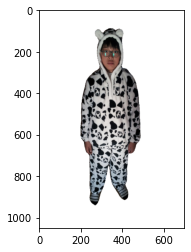

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(result)

#Influencer Recommendation with Cosine Similarity

In [ ]:
#코사인 유사도 계산 함수(무신사 추천 ipynb와 동일)
import torch

def cosine_sim(img1, img2):
  tensor=transforms.ToTensor()
  img1=torch.flatten(tensor(img1));img2=torch.flatten(tensor(img2))
  sim=torch.nn.CosineSimilarity(dim=0)
  output=sim(img1, img2)
  return output.item()

In [ ]:
def recommend_influencer(imgs,df):
 """
 Input:
  imgs=list of segmented images
  df=pandas dataframe with the influencer list column
 Output:
  image_score=tuple list of each imgs, (similarity score, influencer account)
 """

 image_score=[]
 for image in imgs:
  score=[(0.0,'@'),(0.0,"@")]
  for name in list(df['리스트']):
   with open('/content/drive/MyDrive/인플루언서정보_샘플1/'+name+'/data.json', 'r') as f: #json file 로드하여 post id 추출
    json_data = json.load(f)
    score_list=[]
    
   for i in range(len(json_data)):
     filename='/content/drive/MyDrive/인플루언서정보_샘플1/'+name+'/images'+str(json_data[i]['post_id'])+'_crop.jpg'
     try: 
      input_image = Image.open(filename)
      input_image = input_image.convert("RGB").resize((700,1050)) #image convert & resize
      output=cosine_sim(image, input_image) #Cosine similarity Calculation
      score_list.append(output)
     except:
      None
   avg=np.mean(np.array(score_list))
   print(avg)
   if avg>=score[1][0]: #Compare with the lowest similarity
     score[1]=(avg,name)
     score.sort(key=lambda x:x[0],reverse=True) #sort in reverse
  image_score.append(score)

 image_score.sort(key=lambda x:x[0],reverse=True)
 return image_score[:3] #Show the influencer up to 3; if same account reappears, recommend the second-re

In [ ]:
imgs=[img_seg("/content/drive/MyDrive/카리나1.jpg"),img_seg("/content/drive/MyDrive/카리나2.jpg"),img_seg("/content/drive/MyDrive/카리나3.jpg")]
_=recommend_influencer(imgs,df)

0.8790656129519144
0.9281381408373515
0.9148121805026613
0.9429984986782074
0.8060572907842439
0.924393153959705
0.940143100420634
0.9350794573624929
0.9212592326361557
0.9344654849597386
0.9354977051417033
0.9375734945138295
0.9523115376631419
0.9375520669496976
0.9443220635255177
0.8996450216681869
0.9176881765497142
nan
0.9108801186084747
0.9364558437040874
nan
0.9440268059571584
0.9362102813190885
0.9356264372666677
0.9103021601835887
0.9367404333476362
0.9237433274586996
0.9253778616587321
0.9369935603702769
0.944655179977417
0.9294223423515048
0.9235100274284681
0.9342556158701579
0.9293030520965313
0.925011259317398
nan
0.9427077046462468
0.9445561369260153
0.9277498602867127
0.9150646905104319
0.9390376025232775
0.9369099204029355
0.9324684182802836
0.9282834340225566
0.8767118917571174
0.8455834686756134
0.9402422944704691
0.9362305505522366
0.9246137241522471
0.9203402554547345
0.9035425164869854
0.9283012270927429
0.9379306867204863
0.9298019432104551
0.936784827709198
0.917

In [ ]:
_

[[(0.9523115376631419, '@_zia_mood'), (0.944655179977417, '@campo_look')],
 [(0.9461104869842529, '@337janggoon'), (0.9447664002577464, '@e_wolly')],
 [(0.9323292553424836, '@mini.d31'), (0.9282581726710002, '@_zia_mood')]]
